In [134]:
import pandas as pd
import numpy as np

In [135]:
import sqlite3

In [136]:
from datetime import datetime, timedelta

In [137]:
conn = sqlite3.connect('installments_db')

In [138]:
print(conn.total_changes)

0


In [139]:
# Crie um cursor para executar consultas SQL
cursor = conn.cursor()

In [140]:
# Execute uma consulta SQL para retornar os nomes de todas as tabelas no banco de dados
cursor.execute("SELECT * FROM installments")
resultado = cursor.fetchall()

# Imprima o resultado na tela
for tabela in resultado:
    print(tabela)

(1, '2023-05-08', 1000.0, 12, 0.05)
(2, '2023-06-08', 800.0, 8, 0.03)
(3, '2023-07-08', 1500.0, 10, 0.08)


## Faking Values MOCKED

In [141]:
N_REGISTERS = 3

In [142]:
LIST_INSTALLMENTS = np.random.randint(1,25,N_REGISTERS)

In [143]:
LIST_VALUES = np.random.randint(1,250,N_REGISTERS) * 10

In [144]:
def t():
    return (datetime(2023,1,1) - ((-1)**(np.random.randint(1000)))*timedelta(days=np.random.randint(100)))

In [145]:
LIST_DATES = list()
for i in range(N_REGISTERS):
    LIST_DATES.append(t().date())

In [146]:
LIST_RATES = np.random.rand(N_REGISTERS) / 10

In [147]:
df = pd.DataFrame({
    'payment_id' : range(N_REGISTERS),
    'date' : LIST_DATES,
    'value' : LIST_VALUES,
    'installments_number' : LIST_INSTALLMENTS,
    'rate' : LIST_RATES
})

In [148]:
df['installment_value'] = round(df['value'] / df['installments_number'], 2)

In [157]:
df

,payment_id,date,value,installments_number,rate,installment_value
0,0,2022-10-30,1460,14,0.006620,104.29
1,1,2022-09-28,1970,21,0.097098,93.81
2,2,2022-12-06,330,7,0.073726,47.14


# GETTING THE MAXIMUM DATE 

In [149]:
def get_max_date(N, date):
    MAX_DATE = (date + timedelta(days=int(N*30)))
    return MAX_DATE

In [150]:
MAX_DATE = df.apply(lambda row : get_max_date(row['installments_number'], row['date']), axis=1).max()

In [151]:
# ONE MORE MONTH FOR SAFETY REASONS
MAX_DATE = MAX_DATE + timedelta(30)

In [152]:
MIN_DATE = df['date'].min()

In [164]:
DATES = pd.date_range(MIN_DATE, MAX_DATE, freq='D').date

In [165]:
df_total = pd.DataFrame(columns=DATES)

In [166]:
# ! pip install monthdelta

In [167]:
df_total

,2022-09-28,2022-09-29,2022-09-30,2022-10-01,2022-10-02,2022-10-03,2022-10-04,2022-10-05,2022-10-06,2022-10-07,...,2024-07-10,2024-07-11,2024-07-12,2024-07-13,2024-07-14,2024-07-15,2024-07-16,2024-07-17,2024-07-18,2024-07-19


# Creating individual dataframe with dates for each payment register

In [168]:
from monthdelta import monthdelta

In [169]:
def transform_register(x):
    # Collecting the register values
    FIRST_DATE = x['date']
    N = x['installments_number']
    PAYMENT_ID = x['payment_id']

    LIST_DATES_REGISTER = (pd.date_range(FIRST_DATE, periods=N, freq='MS') + timedelta(days=FIRST_DATE.day-1)).date

    df_aux = pd.DataFrame({'date': LIST_DATES_REGISTER})
    df_aux['value'] = x['installment_value']

    df_aux = df_aux.pivot_table(index=None, columns='date', values='value')
    
    df_aux['PAYMENT_ID'] = PAYMENT_ID

    return df_aux.set_index('PAYMENT_ID')

In [170]:
for index, row in df.iterrows():
    df_payment_info = transform_register(row)
    df_total = pd.concat([df_total, df_payment_info], axis=0)

In [173]:
df_t =df_total.fillna(0)

In [182]:
df_to_plot = df_t.sum().reset_index().rename(columns={'index':'Data', 0:'Valor_a_Receber'})

In [183]:
df

,payment_id,date,value,installments_number,rate,installment_value
0,0,2022-10-30,1460,14,0.006620,104.29
1,1,2022-09-28,1970,21,0.097098,93.81
2,2,2022-12-06,330,7,0.073726,47.14


In [184]:
df_to_plot[df_to_plot['Valor_a_Receber'] != 0].Data.unique

<bound method Series.unique of 30     2022-10-28
61     2022-11-28
63     2022-11-30
91     2022-12-28
93     2022-12-30
100    2023-01-06
122    2023-01-28
124    2023-01-30
131    2023-02-06
153    2023-02-28
155    2023-03-02
159    2023-03-06
181    2023-03-28
183    2023-03-30
190    2023-04-06
212    2023-04-28
214    2023-04-30
220    2023-05-06
242    2023-05-28
244    2023-05-30
251    2023-06-06
273    2023-06-28
275    2023-06-30
281    2023-07-06
303    2023-07-28
305    2023-07-30
334    2023-08-28
336    2023-08-30
365    2023-09-28
367    2023-09-30
395    2023-10-28
397    2023-10-30
426    2023-11-28
428    2023-11-30
456    2023-12-28
458    2023-12-30
487    2024-01-28
518    2024-02-28
547    2024-03-28
578    2024-04-28
608    2024-05-28
639    2024-06-28
Name: Data, dtype: object>

In [185]:
import seaborn as sns
import matplotlib.pyplot as plt

In [186]:
df_to_plot = df_to_plot

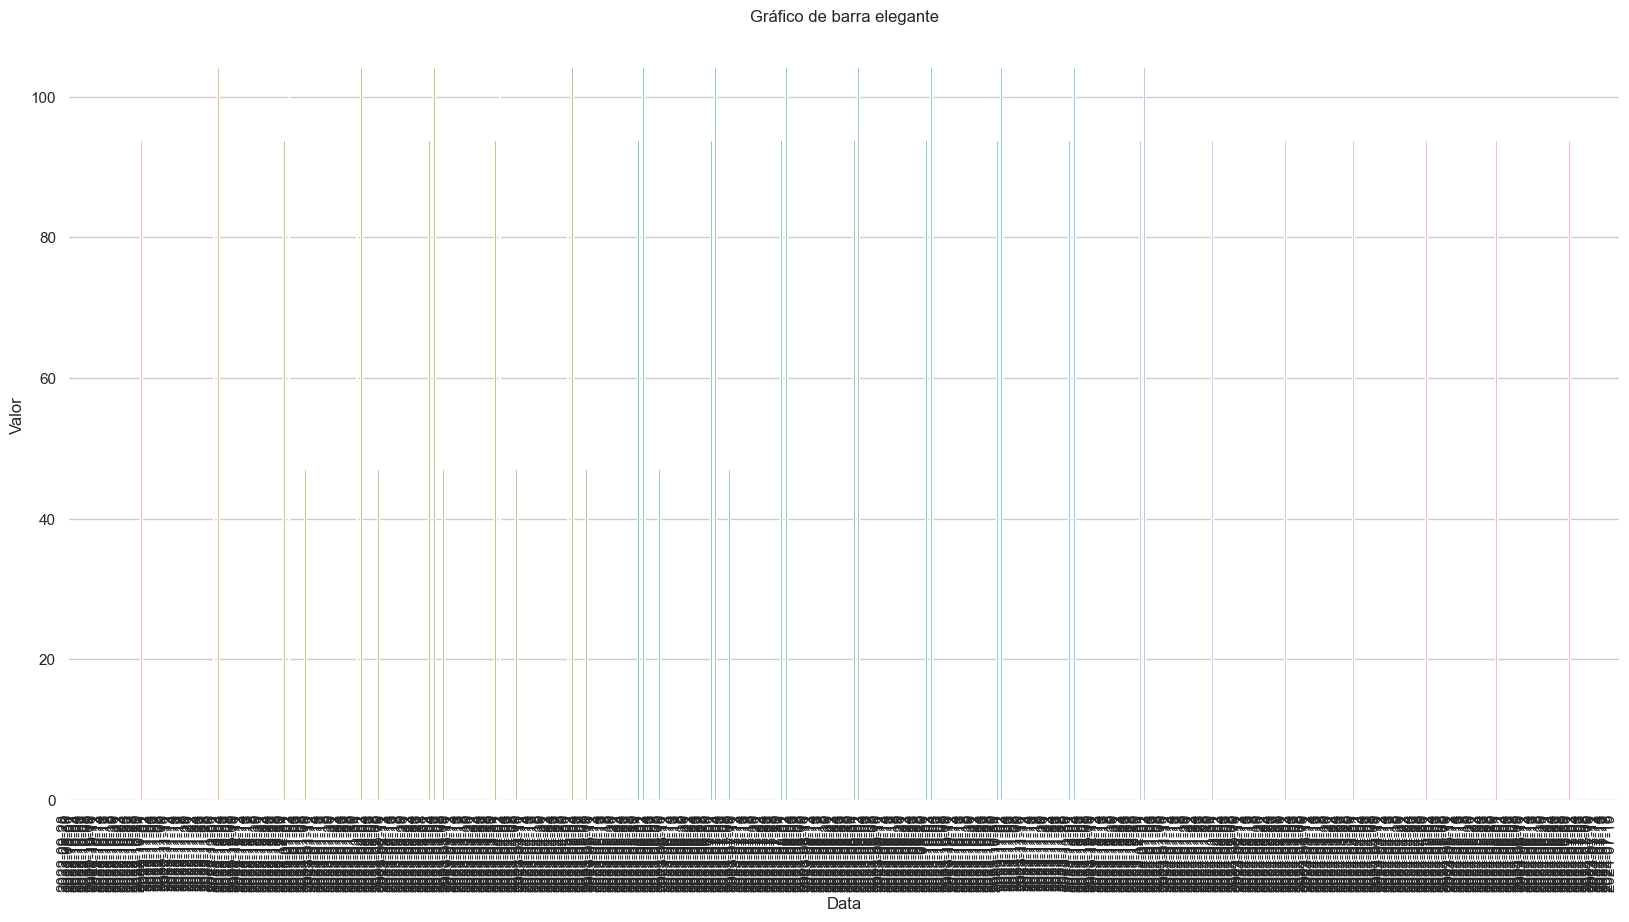

In [187]:
fig, ax = plt.subplots(figsize=(20,10))

# Criar um gráfico de barra elegante usando Seaborn
sns.set(style='whitegrid') # define o estilo do gráfico
ax = sns.barplot(x=df_to_plot.Data, y=df_to_plot['Valor_a_Receber'], data=df) # cria o gráfico de barra

# Personalizar o gráfico
ax.set(xlabel='Data', ylabel='Valor', title='Gráfico de barra elegante')
sns.despine(left=True, bottom=True) # remove as bordas do gráfico
plt.xticks(rotation=90, ha='right') # gira e alinha as datas no eixo x

# Exibir o gráfico
plt.show()